# Team F1's Linear Regression model

Team members include Patrick, Carter, Jaegeon and Merlin

In [43]:
#importing all the different libraries that we will need for this part. 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import numpy as np

Here we pull in the data that will to be used for our predictors and qualifiers.  We can pull from two different csv files, but should be careful that they line up. <br>
The list in the X dataframe should contain all the different columns that we want to use, such as "gap_between_mean" or "circuitType_RACE"

In [78]:
xdata = pd.read_csv(r"C:\Users\merli\Documents\ERDOS\erdos_ds_f1\Merlin preview\gaps and circuit type (no DNF).csv")  #or we can use different files for each, but they should be in the right order

ydata = pd.read_csv(r"C:\Users\merli\Documents\ERDOS\erdos_ds_f1\Patrick\Average Local Positions.csv")

xdata2 = pd.read_csv(r"C:\Users\merli\Documents\ERDOS\erdos_ds_f1\paceRankStartPositionDeltas.csv")

xdata = pd.merge(xdata,xdata2, on = "raceId", how = 'inner')
#"Bgap_mean","Bgap_average" ,"First_ten_gap", "circuitType_STREET", "circuitType_RACE","circuitType_ROAD"
X  = xdata[ ["absGridDelta"]]



X = X.fillna(3000)  #getting rid of any nan variables, and replaces them with 1000, for only a couple NaNs, shouldn't make a big different. 


Y = ydata[ "average_local_position"]  #this is our target, what we are trying to predict, and will use this to test our predictive model. 


X_train,X_test , Y_train, Y_test = train_test_split(X,Y , test_size= 0.2, shuffle=True, random_state= 117)

#print(X[X.isnull().any(axis=1)])


In [62]:
type(Y_train)

pandas.core.series.Series

In [45]:
#create cross-validation sets for model selection
kfold = KFold(n_splits = 4, shuffle=True, random_state=42)

Here we create the pipeline for how our model will be run.  We are using the Linear Regression model, and we are normalizing our predictor values via StandaScalar.

In [ ]:
"""
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

class ColumnTransformerWithNames(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, feature_names):
        self.transformer = transformer
        self.feature_names = feature_names

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        transformed = self.transformer.transform(X)
        if hasattr(transformed, 'toarray'):  # handle sparse matrix
            transformed = transformed.toarray()
        return pd.DataFrame(transformed, columns=self.get_feature_names_out())

    def get_feature_names_out(self):
        return self.transformer.get_feature_names_out(self.feature_names)

numeric_features = ['age', 'income']
numeric_transformer = StandardScaler()

categorical_features = ['gender', 'country']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

column_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

df_feature_names = numeric_features + categorical_features
wrapped_transformer = ColumnTransformerWithNames(column_transformer, df_feature_names)

pipeline = Pipeline(steps=[
    ('preprocessor', wrapped_transformer)
])
"""

In [70]:
pipe = Pipeline ([
    ('scalar', StandardScaler() ),  #normalizing our features aka the predictors
    ('model' , LinearRegression() )  # this is the model that we are using, which can be anything we want. 
])



preprocessor = ColumnTransformer(
    transformers=[
        ('transformer', PolynomialFeatures(degree=3, include_bias=False), ["Bgap_median","absGridDelta"])  #this picks which columns to transform with our polynomial
    ],
    remainder='passthrough',
    force_int_remainder_cols=False
).set_output(transform = 'pandas')

pipe2 = Pipeline ([
    ('scalar', StandardScaler() ),  #normalizing our features aka the predictors
    ('poly',PolynomialFeatures(degree=2, include_bias=False)), #thisputs our preprocessor in our pipeline
    # ('preprocessor', PolynomialFeatures(degree=3, include_bias=False ) ),
    ('reg' , LinearRegression())  # this is the model that we are using, which can be anything we want. 
])


In [63]:
type(preprocessor.fit(X_train,Y_train))

sklearn.compose._column_transformer.ColumnTransformer

Here is where we train the model, making sure not to use any of our testing data.  That would mean there is data leakage. 

In [6]:

pipe2.fit(X_train,Y_train)  #here we are fitting our model with the testing data,  DO NOT INCLUDE THE TEST PARTITIONS




Pipeline(steps=[('scalar', StandardScaler()),
                ('poly', PolynomialFeatures(degree=3, include_bias=False)),
                ('reg', LinearRegression())])

### Model Selection: Look at performance on cross-validation sets

In [79]:
rmses = np.zeros(4)
Y_train_log = np.log(Y_train)
Y_test_log =np.log(Y_test)

test_pred = []
test_hold = []

for i, (train_index, test_index) in enumerate(kfold.split(X_train, Y_train)):
    X_train_train = X_train.iloc[train_index,:]
    Y_train_train = Y_train.iloc[train_index]

    X_holdout = X_train.iloc[test_index,:]
    Y_holdout = Y_train.iloc[test_index]

    pipe2.fit(X_train_train,Y_train_train)

    y_pred = pipe2.predict(X_holdout)

    test_pred = y_pred
    test_hold = Y_holdout

    rmses[i] = root_mean_squared_error(y_pred,Y_holdout)

print(rmses.mean())

0.8533049960103747


## Final Step: Predict on test set (only after final model is chosen)

Now we can use our trained model to make predictions from the testing predictors, and compare them to the actual predictors from the testing set. 

In [80]:

Y_pred = pipe2.predict(X_test) 

mse = mean_squared_error(Y_pred, Y_test)
r2 = r2_score(Y_pred,Y_test)


print(f"Mean squared error: {mse}")
print(f"R^2 value : {r2}")

Mean squared error: 0.6791668085361191
R^2 value : -3.0894411391954115


In [14]:
import matplotlib.pyplot as plt

#plt.plot(ydata["raceId"],ydata['average_local_position'])

#plt.plot(Y_pred)

In [88]:
print(len(Y_pred))
print(Y_test.to_list())

141
[3.411764705882353, 3.375, 3.263157894736842, 2.3076923076923075, 1.6923076923076923, 1.4, 1.4545454545454546, 3.25, 2.4615384615384617, 1.818181818181818, 1.0, 1.7777777777777777, 2.7058823529411766, 1.7777777777777777, 2.7, 3.4285714285714284, 1.6923076923076923, 1.4, 3.1, 3.25, 0.7272727272727273, 1.5, 2.2857142857142856, 1.75, 1.5555555555555556, 2.75, 1.5, 2.0, 1.875, 3.733333333333333, 1.3333333333333333, 2.0, 4.222222222222222, 3.0526315789473686, 3.142857142857143, 1.25, 2.571428571428572, 1.0, 2.375, 1.0769230769230769, 1.4666666666666666, 1.375, 1.0666666666666669, 2.769230769230769, 1.8, 1.0, 3.473684210526316, 1.5714285714285714, 4.095238095238095, 2.75, 1.375, 1.4285714285714286, 2.0, 1.5555555555555556, 1.8461538461538465, 1.3333333333333333, 2.875, 4.0, 1.2, 1.0588235294117647, 0.9230769230769232, 2.625, 1.6, 1.6, 2.0, 1.4545454545454546, 2.0, 3.090909090909091, 4.333333333333333, 1.2857142857142858, 1.2941176470588236, 1.7142857142857142, 3.8666666666666663, 0.8, 2.

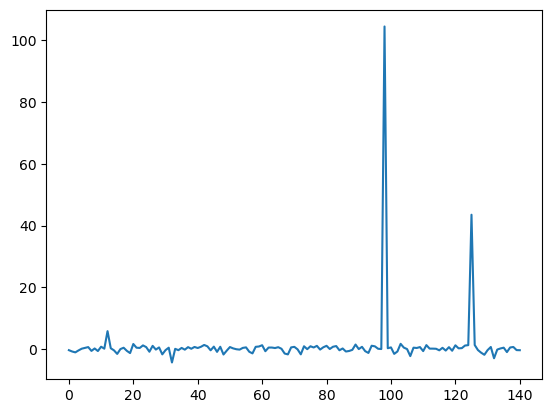

In [94]:
plt.plot((Y_pred- Y_test.to_list()))


In [13]:
np.exp(np.log(12))

np.float64(12.0)

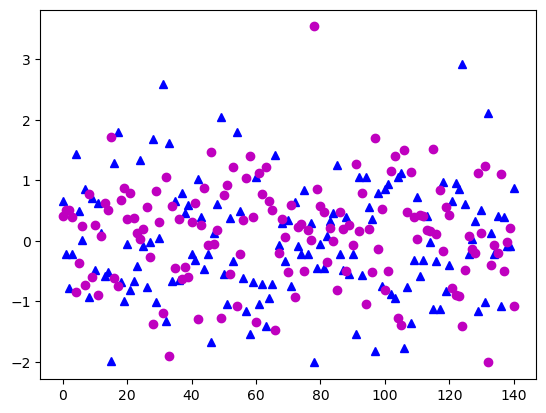

In [84]:
#plt.plot(Y_train_log,'o')
plt.plot(test_hold.to_list() - np.mean(test_hold.to_list()),'b^')
plt.plot(test_pred - test_hold.to_list(), 'mo')

(-5.0, 10.0)

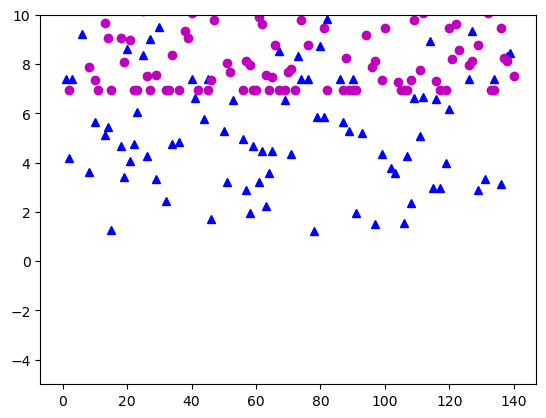

In [83]:
plt.plot(np.exp(test_hold.to_list()),'b^')
plt.plot(np.exp(test_pred), 'mo')
plt.ylim(-5,10)

In [36]:
X[X.isnull().any(axis = 1)]

,Bgap_median,circuitType_RACE,circuitType_ROAD,absGridDelta
